In [525]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from os import listdir

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve


from main import df_scrolling_object

import my_func
import importlib
importlib.reload(my_func)

from pandas_profiling import ProfileReport

In [526]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [527]:
data_train = pd.read_csv('kaggle/train.csv')
data_subm = pd.read_csv('kaggle/sample_submission.csv')
data_test = pd.read_csv('kaggle/test.csv')
data_train['train'] = 1 # трейн
data_test['train'] = 0 # тест
data = data_train.append(data_test, sort=False).reset_index(drop=True)

# ОПИСАНИЕ СТОЛБЦОВ
| Столбец        |     Значение                    |
|:---------------|:--------------------------------|
|client_id	     |    идентификатор клиента        |  
|education	     |   уровень образования           | 
|sex	         | пол заёмщика  
|age             |	возраст заёмщика  
|car	         |флаг наличия автомобиля  
|car_type	     |флаг автомобиля-иномарки  
|decline_app_cnt |	количество отказанных прошлых заявок  
|good_work       |	флаг наличия «хорошей» работы  
|bki_request_cnt |	количество запросов в БКИ  
|home_address	 |категоризатор домашнего адреса  
|work_address	 |категоризатор рабочего адреса  
|income	         |доход заёмщика  
|foreign_passport|	наличие загранпаспорта  
|sna | связь заемщика с клиентами банка
|first_time | давность наличия информации о заемщике
|score_bki | скоринговый балл по данным из БКИ
|region_rating | рейтинг региона
|app_date | дата подачи заявки
|default	     |наличие дефолта  

In [528]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

# Заполнение NAN
### По итогам анализа была выявлена небольшая зависимость между уровнем образовавния
### и доходом (см. EDA), в связи с чем заполнение NAN выполняется с учетом среднего дохода
### на группу, объединенную по образованию

In [529]:
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,NaN,0
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,NaN,0
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,NaN,0
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,NaN,0


## Рассмотрим все признаки средствами ProfileReport

In [530]:
profile = ProfileReport(data)
profile.to_widgets()

# EDA и анализ признаков
## Разведывательный анализ выведен в [отдельный ноутбук](https://github.com/aberkoveo/skillfactory/blob/master/Projects/Project_4/scoring_EDA.ipynb)


# Генерация новых признаков

На основе исследованных распределений и проверки гипотез были выработаны наиболее оптимальные комбинации признаков, улучшающих классифицирующую способность модели.

data.drop(['app_date'], axis=1, inplace=True)  
data['sna_age'] =  data['age'] * data['sna']   
data['age_eduaction'] = data['age'] / (data['education'] + 1)  
data['age_foreign_pass'] = data['age'] / data['foreign_passport'].apply(lambda x: 1/1.1 if x==1 else 1.1)  
data['age_good_work'] = data['age'] / data['good_work'].apply(lambda x: 1/1.2 if x==1 else 1.2)  
data['work_adr_age'] = data['age'] / data['work_address']  
data['bki_cnt_word_adr'] = data['bki_request_cnt'] / data['work_address']  
data['score_bki_work_adr'] = data['score_bki'] - data['work_address']  
data['bki_cnt_first_time'] = data['bki_request_cnt'] * data['first_time']  
data['region_age'] = data['age'] * data['decline_app_cnt']  
data['car_type_full'] =  data['car_type'] + data['car']  

# ВЫБРОСЫ
Все нумерные признаки оставляем с выбросами, как таковые выбросы были   
обнаружены в колонке дохода, но для любого сокращенного диапазона по этому признаку   
скор падает

# Формирование и подготовка данных
Создадим объект класса df_scrolling_object из модуля main  
для дальнейшей работы с данными, так же заранее сохраним значения client_id для сабмита на Kaggle

In [531]:
import main
from main import df_scrolling_object
import importlib
importlib.reload(main)
data_obj = df_scrolling_object(data)
subm_client_id = data[data.train==0]['client_id']

Data Class created
Features Added


Выполним предобработку данных, в которую входит логорифмирование нумерных переменных
и кодирование  бинарных

In [532]:
data = data_obj.preproc_data()

Preprocessing


# Определение важности признаков

<AxesSubplot:>

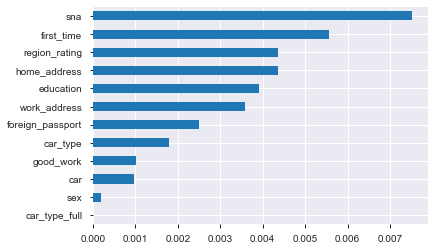

In [533]:
bin_cols = data_obj.bin_cols
cat_cols = data_obj.cat_cols

data_cat = data[data.train==1].copy()
imp_cat = Series(mutual_info_classif(data_cat[bin_cols + cat_cols], data_cat['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

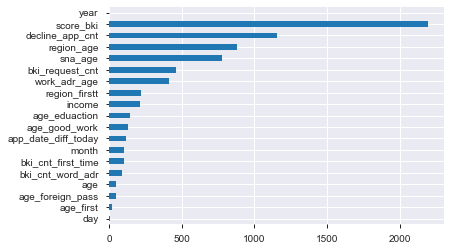

In [534]:
num_cols = data_obj.num_cols
new_num_cols = data_obj.new_num_cols
data_num = data[data.train==1].copy()
imp_num = Series(f_classif(data_num[num_cols+new_num_cols], data_num['default'])[0], index = num_cols+new_num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Отбор признаков будет выполняться далее средствами RFE

# Формируем переменные для модели логической регрессии
Исходный датасет предобрабатывается, так же создаются DUMMY переменные и выполняется   
стандартизация нумерных признаков

In [535]:
X, Y = data_obj.return_XY_train()

Preprocessing
StandardScaler-Dummies done


In [536]:
X.shape

(73799, 54)

# Отбор признаков
По итогам отладки модели было выявлено оптимальное количество признаков 
n_features_to_select=50

In [537]:
from sklearn.feature_selection import RFE
C = 1
penalty = 'l1'
solver = 'liblinear' # BEST

n_features_to_select = 54

# C=4.877612570110835   
# penalty='l1' 
# solver='liblinear'

# C = 1.9463099813601865 
# penalty = 'l2'
# solver = 'newton-cg'

estimator = LogisticRegression(C=C, penalty=penalty, solver=solver,  random_state=RANDOM_SEED)
selector = RFE(estimator, n_features_to_select=n_features_to_select, step=1)
selector = selector.fit(X, Y)

X = selector.transform(X)

In [538]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=RANDOM_SEED)

In [539]:
X.shape

(73799, 54)

# Модель Логистической Регрессии
По итогу отладки гипер-параметров был выбран наиболее оптимальный набор   
С, penalty и solver

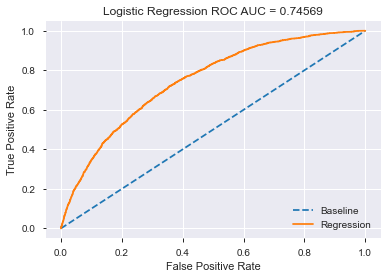

roc_auc=0.745695  C=1.9463099813601865 penalty=l2 solver=newton-cg features=54
[[12879    54]
 [ 1789    38]]


In [540]:
# C = 1
# penalty = 'l2'
# solver = 'newton-cg'

# C = 1.4813022192790921
# penalty = 'l1'
# solver = 'liblinear'

# C=4.877612570110835   
# penalty='l1' 
# solver='liblinear'

C = 1.9463099813601865
penalty = 'l2'
solver = 'newton-cg' # BEST

model = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
y_pred = model.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print(f'roc_auc={round(roc_auc, 6)}  C={C} penalty={penalty} solver={solver} features={n_features_to_select}')
print(confusion_matrix(y_test, y_pred))

# Формируем сабмит для Kaggle

In [541]:

# X_test = data_obj.return_X_test()
# X_test = selector.transform(X_test)
# y_pred_subm = model.predict_proba(X_test)[:,1]

# submit = pd.DataFrame(subm_client_id)
# submit['default'] = y_pred_subm
# submit.to_csv('submission.csv', index=False)

# История результатов отладки
roc_auc=0.745635  C=1.9463099813601865   penalty=l2 solver=newton-cg  n_features_to_select = 53  
roc_auc=0.745602  C=1.9463099813601865   penalty=l2 solver=newton-cg  

roc_auc=0.745508  C=1.9463099813601865   penalty=l2 solver=newton-cg  

roc_auc=0.745533 C=1 penalty=l1 solver=liblinear RFE=50    
roc_auc=0.745533  C=1   penalty=l1 solver=liblinear RFE=52  
roc_auc=0.745415  C=1   penalty=l1 solver=liblinear scorbki forpassp 1 1.2  
roc_auc=0.74549  C=1   penalty=l1 solver=liblinear age / decl cnt  
roc_auc=0.745474  C=1   penalty=l1 solver=liblinear age / region  
roc_auc=0.745405  C=1   penalty=l1 solver=liblinear  first_time x bki cnt  
roc_auc=0.745265  C=1   penalty=l1 solver=liblinear  scor bki - work addr    
roc_auc=0.744641  C=1   penalty=l1 solver=liblinear  scor bki + work addr  
roc_auc=0.745155  C=1   penalty=l1 solver=liblinear
roc_auc=0.745079  C=1   penalty=l1 solver=liblinear  
roc_auc=0.744978  C=1   penalty=l1 solver=liblinear  
roc_auc=0.744955  C=1   penalty=l1 solver=liblinear  + age ~ foreign pass(1.1)  
roc_auc=0.744949  C=1   penalty=l1 solver=liblinear  + age ~ foreign pass(1.2)  
roc_auc=0.744922  C=1   penalty=l1 solver=liblinear  + age ~ foreign pass(1.4)  
roc_auc=0.744845  C=1   penalty=l1 solver=liblinear  + age/ edu  nonlog  
roc_auc=0.744803  C=1   penalty=l1 solver=liblinear  + age* edu  nonlog  
roc_auc=0.744673  C=1   penalty=l1 solver=liblinear  + sna*age  nonlog  
roc_auc=0.744571  C=1   penalty=l1 solver=liblinear  + sna/age  nonlog  
roc_auc=0.744213  C=1   penalty=l1 solver=liblinear  
roc_auc=0.744213  C=1   penalty=l1 solver=liblinear  
roc_auc=0.744709  C=1   p enalty=l2 solver=newton-cg  
roc_auc=0.744682  C=1   penalty=l2 solver=newton-cg  
roc_auc=0.744641  C=1   penalty=l2 solver=newton-cg   
roc_auc=0.744112 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.744088 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.743984 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.7439 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.743433 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.677348  
roc_auc=0.677304  
roc_auc=0.677311 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.677277 C=2.7825594022071245 penalty=l2 solver=  

# Отладка гипер-параметров модели средствами HyperOpt

In [542]:
### HyperOpt Parameter Tuning
from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin

N_FOLDS = 5
MAX_EVALS = 50

def objective(params, n_folds = N_FOLDS):
    """Objective function for Logistic Regression Hyperparameter Tuning"""

    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evaluate based on ROC AUC

    clf = LogisticRegression(random_state=RANDOM_SEED, verbose =0)
    scores = cross_val_score(clf, X, Y, cv=5, scoring='roc_auc')

    # Extract the best score
    best_score = max(scores)

    # Loss must be minimized
    loss = 1 - best_score

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'warm_start' : hp.choice('warm_start', [True, False]),
    'fit_intercept' : hp.choice('fit_intercept', [True, False]),
    'tol' : hp.uniform('tol', 0.00001, 0.0001),
    # 'C' : hp.uniform('C', 0.05, 10),
    'C' : hp.choice('C', np.logspace(0, 4, 10)),
    'solver' : hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'max_iter' : hp.choice('max_iter', range(5,1000)),
    'penalty' : hp.choice('penalty', ['l1' , 'l2'])
}

In [543]:
# Algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
bayes_trials = Trials()

# Optimize
rstate = np.random.RandomState(RANDOM_SEED)
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials, 
rstate=rstate)

100%|██████████| 50/50 [01:57<00:00,  2.35s/trial, best loss: 0.3361351028327513]


In [544]:
best

{'C': 7,
 'class_weight': 1,
 'fit_intercept': 1,
 'max_iter': 642,
 'penalty': 0,
 'solver': 2,
 'tol': 2.3352574146813767e-05,
 'warm_start': 1}

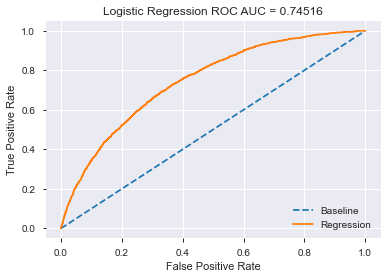

roc_auc=0.745159  C=7   penalty=l1 solver=liblinear
[[12879    54]
 [ 1789    38]]


In [545]:
solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty_list = ['l1' , 'l2']
class_weight_list = [None, 'balanced']
warm_start_list = [True, False]
fit_intercept_list = [True, False]
warm_start_list = [True, False]

max_iter = best['max_iter']
C = best['C']
tol = best['tol']
warm_start = warm_start_list[best['warm_start']]
class_weight = class_weight_list[best['class_weight']]
fit_intercept = fit_intercept_list[best['fit_intercept']]
penalty = penalty_list[best['penalty']]
solver = solver_list[best['solver']]

model = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=RANDOM_SEED
                           )
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
y_pred = model.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print(f'roc_auc={round(roc_auc, 6)}  C={C}   penalty={penalty} solver={solver}')
print(confusion_matrix(y_test, y_pred))

roc_auc=0.745444  C=7   penalty=l1 solver=liblinear  
roc_auc=0.74538  C=4.877612570110835   penalty=l1 solver=liblinear

In [546]:
# data_test = pd.read_csv('kaggle/test.csv')
# data_obj = df_scrolling_object(data[data.train==0])
# X_test = data_obj.return_X()#data[data.train==0].drop('default', axis=1)
# X_test = selector.transform(X_test)
# y_pred_subm = model.predict_proba(X_test)[:,1]

# submit = pd.DataFrame(subm_client_id)
# submit['default'] = y_pred_subm
# submit.to_csv('submission.csv', index=False)

In [547]:
# from sklearn.model_selection import GridSearchCV
# # Добавим типы регуляризации
# penalty = ['l1', 'l2']
# # Зададим ограничения для параметра регуляризации
# C = np.logspace(0, 4, 10)
# # solver
# solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# # Score
# scoring = {'AUC': 'roc_auc'}

# # Добавим типы регуляризации
# iter_ = 50
# epsilon_stop = 1e-3

# # Создадим гиперпараметры
# # hyperparameters = dict(C=C, penalty=penalty, solver=solver)

# hyperparameters = [
#     {'penalty': ['l1'], 
#      'solver': ['liblinear', 'lbfgs', 'newton-cg'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['l2'], 
#      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['none'], 
#      'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
# ]

# model = LogisticRegression()
# # model.fit(X_train, y_train)

# # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0,  scoring=scoring, refit='AUC')

# best_model = clf.fit(X_train, y_train)

# # View best hyperparameters
# print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
# print('Лучшее Solver:', best_model.best_estimator_.get_params()['solver'])

In [548]:
# y_best_prob = best_model.predict_proba(X_test)

# probs = y_best_prob[:,1]

# fpr, tpr, threshold = roc_curve(y_test, probs)
# roc_auc = roc_auc_score(y_test, probs)

# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
# plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc = 'lower right')
# plt.show()

# print(f'roc_auc={round(roc_auc, 6)}  C={C}   penalty={penalty} solver={solver}')
# print(confusion_matrix(y_test, y_pred))

roc_auc=0.745585  C=1   penalty=l1 solver=liblinear RFE = 52  
roc_auc=0.74549  C=1   penalty=l1 solver=liblinear  RFE = 53  
roc_auc=0.745548  C=1   penalty=l1 solver=liblinear RFE=50    
roc_auc=0.744915  C=1   penalty=l1 solver=liblinear RFE=35  
roc_auc=0.745453  C=1   penalty=l1 solver=liblinear RFE=40  
roc_auc=0.745415 C=1 penalty=l1 solver=liblinear FULL X

In [549]:
# # Добавим 
# iter_ = 50
# epsilon_stop = 1e-3

# # Создадим гиперпараметры
# hyperparameters = [
#     {'penalty': ['l1'], 
#      'solver': ['liblinear', 'lbfgs'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['l2'], 
#      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['none'], 
#      'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
# ]

# model = LogisticRegression()

# # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# clf = GridSearchCV(model, hyperparameters, scoring='f1', cv=5, verbose=0, refit='f1')

# clf.fit(X_train, y_train)
# model_2 = clf.best_estimator_

# # View best hyperparameters
# print('Лучшее Penalty:', model_2.get_params()['penalty'])
# print('Лучшее C:', model_2.get_params()['C'])
# print('Лучшее Solver:', model_2.get_params()['solver'])

In [550]:
# y_best_prob = model_2.predict_proba(X_test)

# probs = y_best_prob[:,1]

# fpr, tpr, threshold = roc_curve(y_test, probs)
# roc_auc = roc_auc_score(y_test, probs)

# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
# plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc = 'lower right')
# plt.show()

# print(f'roc_auc={round(roc_auc, 6)}  C={C}   penalty={penalty} solver={solver}')
# print(confusion_matrix(y_test, y_pred))

Лучшее Penalty: l1
Лучшее C: 1291.5496650148827
Лучшее Solver: liblinear

In [551]:
# # The scorers can be either be one of the predefined metric strings or a scorer
# # callable, like the one returned by make_scorer  



# from sklearn.metrics import make_scorer
# from sklearn.metrics import accuracy_score, f1_score
# scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(f1_score)}
# hyperparameters = [
#     {'penalty': ['l1'], 
#      'solver': ['liblinear', 'lbfgs'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['l2'], 
#      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['none'], 
#      'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
# ]
# # Setting refit='AUC', refits an estimator on the whole dataset with the
# # parameter setting that has the best cross-validated AUC score.
# # That estimator is made available at ``gs.best_estimator_`` along with
# # parameters like ``gs.best_score_``, ``gs.best_params_`` and
# # ``gs.best_index_``
# model = LogisticRegression()

# gs = GridSearchCV(model,
#                   param_grid=hyperparameters,
#                   scoring=scoring, refit='AUC', return_train_score=True)
# gs.fit(X_train, y_train)

# results = gs.cv_results_
# model_3 = gs.best_estimator_

In [552]:
# print('Лучшее Penalty:', gs.best_estimator_.get_params()['penalty'])
# print('Лучшее C:', gs.best_estimator_.get_params()['C'])
# print('Лучшее Solver:', gs.best_estimator_.get_params()['solver'])

In [553]:
# model_3 = gs.best_estimator_

In [554]:
# y_best_prob = model_3.predict_proba(X_test)

# probs = y_best_prob[:,1]

# fpr, tpr, threshold = roc_curve(y_test, probs)
# roc_auc = roc_auc_score(y_test, probs)

# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
# plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc = 'lower right')
# plt.show()

# print(f'roc_auc={round(roc_auc, 6)}  C={C}   penalty={penalty} solver={solver}')
# print(confusion_matrix(y_test, y_pred))